# Get data

In [1]:
!pip install gdown
!pip install pyvi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 59.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 57.8 MB/s eta 0:00:00


In [2]:
!gdown 10U3ShbGdakYKIpwvoLRzJEOP_zRRy3zT

Downloading...
From: https://drive.google.com/uc?id=10U3ShbGdakYKIpwvoLRzJEOP_zRRy3zT
To: /kaggle/working/UIT-VSMEC-20230520T124243Z-001.zip
100%|█████████████████████████████████████████| 319k/319k [00:00<00:00, 113MB/s]


In [3]:
!unzip /kaggle/working/UIT-VSMEC-20230520T124243Z-001.zip

Archive:  /kaggle/working/UIT-VSMEC-20230520T124243Z-001.zip
  inflating: UIT-VSMEC/valid_nor_811.xlsx  
  inflating: UIT-VSMEC/test_nor_811.xlsx  
  inflating: UIT-VSMEC/train_nor_811.xlsx  


# Import Files and Libraries

In [6]:
%%capture
!pip install tensorflow_text
!pip install transformers

In [7]:
# nltk imports
from nltk.tokenize import word_tokenize  # tokenize the text == the text is splitted into words in list
from nltk.corpus import stopwords  # this contain common stop words that has no effect in analysis
from nltk.stem import WordNetLemmatizer  # Lemmatization is the process of grouping together the different inflected forms of a word so they can be analyzed as a single item

# sklearn imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # bags of words and TF IDF
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, make_scorer  # classification Metrics
from sklearn.naive_bayes import MultinomialNB  # Multiclassification
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.model_selection import StratifiedKFold  # For stratified splitting (helpful in imbalanced data)
from sklearn.preprocessing import LabelBinarizer  # for Categorical features
from sklearn.model_selection import GridSearchCV  # for tuning parameters
from sklearn.model_selection import train_test_split  # splitting dataset
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn import pipeline
from sklearn import linear_model

# gensim imports
from gensim.models import KeyedVectors  # to save and load vectors
import string
import re
import pandas as pd
import numpy as np
import xgboost as xgb
import catboost as cbt

# tensorflow and keras
import keras
from keras import backend as K
from tensorflow.keras.layers import Embedding
from keras.models import Model
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence, text
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.utils import np_utils
from keras.callbacks import EarlyStopping , ReduceLROnPlateau
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import codecs
import pickle

from pyvi import ViTokenizer
import gensim

# Hugging Face Transformers
from transformers import (pipeline , BertTokenizer,
                          TFBertForSequenceClassification,
                          InputExample, InputFeatures , 
                         AutoTokenizer, TFAutoModelForSequenceClassification,
                         TFRobertaModel, TFGPT2Model, RobertaTokenizer, GPT2Tokenizer)

In [8]:
train_df = pd.read_excel('/kaggle/working/UIT-VSMEC/train_nor_811.xlsx')
test_df = pd.read_excel('/kaggle/working/UIT-VSMEC/test_nor_811.xlsx')

train_df = train_df.iloc[:,1:]
test_df = test_df.iloc[:,1:]

train_df.head()
test_df.head()

,Emotion,Sentence
0,Sadness,người ta có bạn bè nhìn vui thật
1,Surprise,cho nghỉ viêc mói đúng sao goi là kỷ luật
2,Disgust,kinh vãi 😡
3,Fear,nhà thì không xa lắm nhưng chưa bao giờ đi vì ...
4,Anger,bố không thích nộp đấy mày thích ý kiến không


In [9]:
print(train_df.shape)
print(test_df.shape)

(5548, 2)
(693, 2)


In [10]:
unique_sentiments = train_df.Emotion.unique()
unique_sentiments

array(['Other', 'Disgust', 'Enjoyment', 'Anger', 'Surprise', 'Sadness',
       'Fear'], dtype=object)

<AxesSubplot: >

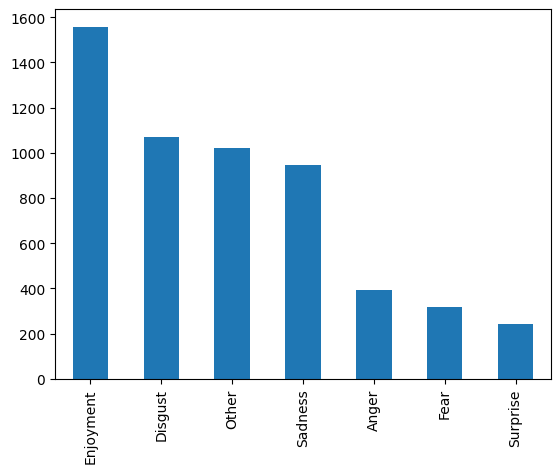

In [11]:
train_df.Emotion.value_counts().plot.bar()

<AxesSubplot: >

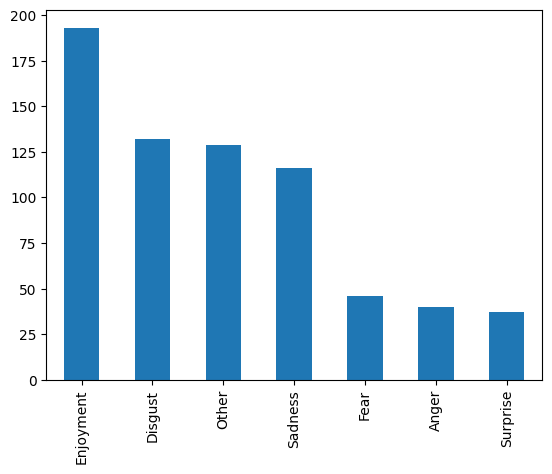

In [12]:
test_df.Emotion.value_counts().plot.bar()

In [13]:
# mapping to the sentiment column 

dicto = {'Disgust': 0, 'Enjoyment': 1 , 'Anger': 2, 'Surprise': 3, 'Sadness': 4, 'Fear': 5, 'Other': 6}

train_df.Emotion = train_df.Emotion.map(dicto)
test_df.Emotion = test_df.Emotion.map(dicto)

In [17]:
test_df.head()

,Emotion,Sentence
0,4,người ta có bạn bè nhìn vui thật
1,3,cho nghỉ viêc mói đúng sao goi là kỷ luật
2,0,kinh vãi 😡
3,5,nhà thì không xa lắm nhưng chưa bao giờ đi vì ...
4,2,bố không thích nộp đấy mày thích ý kiến không


In [19]:
def classical_model(train_df, test_df , bow=False, TFIDF=False, Ngram=False,
                    model=linear_model.LogisticRegression(solver='liblinear')):
    '''
    Automates classical models to train and evaluate Sentiment Analysis Models.

    Args:
    train_df, test_df : pandas DataFrame
        DataFrame with columns Sentence and Emotion
    bow : bool
        Flag for using bag of words (binary, count, or frequency)
    TFIDF : bool
        Flag for using Tfidf vectorization
    Ngram : tuple
        Shape of Ngram range (e.g. (1,2) for bigrams)
    model : scikit-learn estimator
        Model to be used for training

    Returns:
    None
    '''


    # Initiate kfold class from model_selection module
    np.random.seed(0)


    if bow:
        count_vec = CountVectorizer(tokenizer=word_tokenize, token_pattern=None)
    elif TFIDF:
        count_vec = TfidfVectorizer(tokenizer=word_tokenize, token_pattern=None)
    elif Ngram:
        count_vec = CountVectorizer(tokenizer=word_tokenize, token_pattern=None, ngram_range=Ngram)

    count_vec.fit(train_df.Sentence)
    xtrain = count_vec.transform(train_df.Sentence)
    xtest = count_vec.transform(test_df.Sentence)
    model.fit(xtrain, train_df.Emotion)
    preds = model.predict(xtest)
    accuracy_precision = precision_score(test_df.Emotion, preds, average='macro')
    accuracy_recall = recall_score(test_df.Emotion, preds, average='macro')
    print('precision score:', accuracy_precision)
    print('recall score:', accuracy_recall)
    print("========================================================")

    print(classification_report(test_df.Emotion, preds))

# Model 1 : Logistic + BOW

In [20]:
#Baseline model let's start with a logistic regression model since it is the fastest for high dimensional sparse data

classical_model(train_df, test_df , bow =True,model=linear_model.LogisticRegression(solver = 'liblinear'))

precision score: 0.5815327032247299
recall score: 0.49640963700261315
              precision    recall  f1-score   support

           0       0.51      0.52      0.51       132
           1       0.61      0.72      0.66       193
           2       0.36      0.25      0.29        40
           3       0.71      0.27      0.39        37
           4       0.63      0.59      0.61       116
           5       0.77      0.59      0.67        46
           6       0.48      0.54      0.51       129

    accuracy                           0.57       693
   macro avg       0.58      0.50      0.52       693
weighted avg       0.57      0.57      0.56       693



# Model 2 : NaiveBayes + BOW

In [21]:
# Lets try with NaiveBayes model 

classical_model(train_df, test_df ,bow = True,model = MultinomialNB()) # multiclassification

precision score: 0.5469550809353907
recall score: 0.42595634353686523
              precision    recall  f1-score   support

           0       0.44      0.61      0.51       132
           1       0.55      0.69      0.62       193
           2       0.43      0.25      0.32        40
           3       0.60      0.08      0.14        37
           4       0.61      0.58      0.60       116
           5       0.71      0.37      0.49        46
           6       0.47      0.40      0.44       129

    accuracy                           0.52       693
   macro avg       0.55      0.43      0.44       693
weighted avg       0.53      0.52      0.51       693



# Model 3 : Naive Bayes with TFIDF


In [22]:
# Now lets try with TF-IDF vectorizer instead of bag of words to MultinomialNB().

classical_model(train_df, test_df, model= MultinomialNB(),TFIDF=True)

precision score: 0.3107018415761585
recall score: 0.3052240704159713
              precision    recall  f1-score   support

           0       0.48      0.54      0.51       132
           1       0.42      0.89      0.58       193
           2       0.00      0.00      0.00        40
           3       0.00      0.00      0.00        37
           4       0.77      0.41      0.53       116
           5       0.00      0.00      0.00        46
           6       0.50      0.30      0.38       129

    accuracy                           0.47       693
   macro avg       0.31      0.31      0.28       693
weighted avg       0.43      0.47      0.42       693



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:13

# Model 4 : Naive Bayes with Ngrams


In [23]:
# Now to the baseline bag of word Naivebayes model lets apply Ngrams  and compare the results.

# Lets try with NaiveBayes model 

classical_model(train_df, test_df, model = MultinomialNB(), Ngram=(1,2))

precision score: 0.5274402784369562
recall score: 0.3516363282101255
              precision    recall  f1-score   support

           0       0.38      0.64      0.48       132
           1       0.52      0.81      0.63       193
           2       0.75      0.07      0.14        40
           3       0.00      0.00      0.00        37
           4       0.62      0.48      0.54       116
           5       0.90      0.20      0.32        46
           6       0.52      0.26      0.34       129

    accuracy                           0.49       693
   macro avg       0.53      0.35      0.35       693
weighted avg       0.52      0.49      0.45       693



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:13

# Data preprocessing

In [25]:
def create_stopwordlist():
    f = codecs.open('/kaggle/input/vietnamese-stopwords/vietnamese-stopwords.txt', encoding='utf-8')
    data = []
    null_data = []
    for i, line in enumerate(f):
        line = repr(line)
        line = line[1:len(line)-3]
        data.append(line)
    return data

In [26]:
stopword_vn = create_stopwordlist()

In [27]:
import string

def tokenize(text):
    #text =  text.translate(str.maketrans('', '', string.punctuation))
    return [word for word in word_tokenize(text.lower()) if word not in stopword_vn]

In [28]:
def new_classical_model(train_df, test_df , option='generate', bow=False, TFIDF=False, Ngram=False,
                    model=linear_model.LogisticRegression(solver='liblinear')):
    '''
    Automates classical models to train and evaluate Sentiment Analysis Models.

    Args:
    train_df, test_df : pandas DataFrame
        DataFrame with columns Sentence and Emotion
    bow : bool
        Flag for using bag of words (binary, count, or frequency)
    TFIDF : bool
        Flag for using Tfidf vectorization
    Ngram : tuple
        Shape of Ngram range (e.g. (1,2) for bigrams)
    model : scikit-learn estimator
        Model to be used for training

    Returns:
    None
    '''

    # Initiate kfold class from model_selection module
    np.random.seed(0)

    if option == 'generate':
        if bow:
            vectorizer = CountVectorizer(tokenizer = tokenize, token_pattern=None)
        elif TFIDF:
            vectorizer = TfidfVectorizer(tokenizer = tokenize, token_pattern=None)
        elif Ngram:
            vectorizer = CountVectorizer(tokenizer = tokenize, ngram_range=Ngram, token_pattern=None)
    elif option == 'load':
        if bow:
            vectorizer = CountVectorizer(vocabulary = pickle.load(open('../input/kpdl-data/vocabulary_2.pkl', 'rb')), ngram_range=(1,3), max_df=0.8, min_df=5, max_features = 15000)
        elif TFIDF:
            vectorizer = TfidfVectorizer(vocabulary = pickle.load(open('../input/kpdl-data/vocabulary_2.pkl', 'rb')), ngram_range=(1,3), min_df=5, max_df= 0.8, max_features=15000)

    vectorizer.fit(train_df.Sentence)
    xtrain = vectorizer.transform(train_df.Sentence)
    xtest = vectorizer.transform(test_df.Sentence)
    model.fit(xtrain, train_df.Emotion)
    preds = model.predict(xtest)
    accuracy_precision = precision_score(test_df.Emotion, preds, average='macro')
    accuracy_recall = recall_score(test_df.Emotion, preds, average='macro')
    print('precision score:', accuracy_precision)
    print('recall score:', accuracy_recall)
    print("========================================================")

    print(classification_report(test_df.Emotion, preds))

## Model 5 : cleaned text Naive Bayes + BOW

In [13]:
#Now lets try this on our baseline MultinomialNB bagofwords model

new_classical_model(train_df, test_df, model = MultinomialNB(),bow = True)

precision score: 0.5749853609972477
recall score: 0.38763365091499224
              precision    recall  f1-score   support

       Anger       0.36      0.23      0.28        40
     Disgust       0.42      0.58      0.49       132
   Enjoyment       0.51      0.72      0.59       193
        Fear       0.64      0.35      0.45        46
       Other       0.41      0.34      0.37       129
     Sadness       0.69      0.47      0.56       116
    Surprise       1.00      0.03      0.05        37

    accuracy                           0.49       693
   macro avg       0.57      0.39      0.40       693
weighted avg       0.53      0.49      0.47       693



# Model 6 : Fastext vector with Naive Bayes Baseline

# Train FastText

In [30]:
merge_df = pd.concat([train_df, test_df], ignore_index=True)
x_tokenized = []

for sentence in merge_df['Sentence'].values:
    tokens = [word for word in word_tokenize(sentence.lower()) if word not in stopword_vn]
    x_tokenized.append(tokens)
    
model = gensim.models.FastText(sentences=x_tokenized, vector_size=300, window=3, min_count=5, workers=4)    

#model.save('/kaggle/working/fasttext_model.bin')

In [ ]:
merge_df

In [30]:
# In this model we will use fastText vectors and also convert each word vector in sentence vector.
# The code is taken from https://fasttext.cc/docs/en/english-vectors.html, this code splits each vector by 
# space and return for more info go through the above link.

def sentence_to_vec(sentence, embedding_dict, tokenizer):
    # This function converts a sentence to a vector of word vectors
    words = tokenizer(sentence)
    embedding_list = []
    for word in words:
        if word in embedding_dict:
            embedding_list.append(embedding_dict[word])
    if len(embedding_list) == 0:
        # if no vectors are found, return zeros
        return np.zeros(300)
    embedding_list = np.array(embedding_list)
    vector = embedding_list.sum(axis=0) / len(embedding_list)
    return vector

In [32]:
ft_model  = gensim.models.FastText.load('/kaggle/working/fasttext_model.bin')

In [31]:
!gdown https://thiaisotajppub.s3-ap-northeast-1.amazonaws.com/publicfiles/baomoi.model.bin

Downloading...
From: https://thiaisotajppub.s3-ap-northeast-1.amazonaws.com/publicfiles/baomoi.model.bin
To: /kaggle/working/baomoi.model.bin
100%|████████████████████████████████████████| 708M/708M [00:53<00:00, 13.2MB/s]


In [39]:
# Load embeddings into memory
# print("Loading embeddings")
embeddings_vi = KeyedVectors.load_word2vec_format('/kaggle/input/kpdl-data/baomoi.model.bin', binary=True)

In [ ]:
# Create sentence embeddings
print("Creating sentence vectors")
vectors_train = []
vectors_test = []
for sentence in train_df['Sentence'].values:
    vectors_train.append(sentence_to_vec(sentence=sentence, embedding_dict=embeddings_vi, tokenizer=ViTokenizer.tokenize))
    #vectors_train.append(ft_model.wv.get_sentence_vector(sentence))
for sentence in test_df['Sentence'].values:
    vectors_test.append(sentence_to_vec(sentence=sentence, embedding_dict=embeddings_vi, tokenizer=ViTokenizer.tokenize))
    #vectors_test.append(ft_model.wv.get_sentence_vector(sentence))

vectors_train = np.array(vectors_train)
vectors_test = np.array(vectors_test)


x_train = vectors_train
y_train = train_df['Emotion'].values
x_test = vectors_test
y_test = test_df['Emotion'].values


scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

model = MultinomialNB()
model.fit(x_train_scaled, y_train)
y_pred = model.predict(x_test_scaled)
pres_score = precision_score(y_test, y_pred, average='macro')
rec_score = recall_score(y_test, y_pred, average='macro')
print('Precision and recall scores:', pres_score, rec_score)
print("======================================================")
print(classification_report(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6]))

In [47]:
def scoring(y_train,y_pred):
    return f1_score(y_train,y_pred,average='macro')

count_vec = CountVectorizer(tokenizer = word_tokenize, token_pattern = None)

X_train = count_vec.fit_transform(train_df.Sentence)

parameters = {'alpha': [0.001,0.01,0.1,0.2,0.3,0.5,0.7,1,1.5,1.6,1.8,10,100]}

model = MultinomialNB()

grid_search = GridSearchCV(model , parameters, cv=5, scoring = make_scorer(scoring), n_jobs = -1, verbose= 1)

grid_result = grid_search.fit(X_train, train_df.Emotion)

print('Best params: ', grid_result.best_params_)
print('Best score: ', grid_result.best_score_)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Best params:  {'alpha': 0.2}
Best score:  0.4792960700623011


In [49]:
# Lets also check svm hyperparameters using pipelines

merge_df = merge_df.sample(frac=1,random_state=42).reset_index(drop=True)



count_vec = CountVectorizer(tokenizer = word_tokenize, token_pattern = None)

X_train = count_vec.fit_transform(merge_df.Sentence)

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf','linear']}
 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 1, cv=5, scoring = make_scorer(scoring), n_jobs = -1)
 
# fitting the model for grid search
grid.fit(X_train, merge_df.Emotion)

print('Best params: ', grid.best_params_)
print('Best score: ', grid.best_score_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best params:  {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best score:  0.516251685847836


# Classify text with BERT ( Transfer Learning )

In [102]:
# Load the pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=7)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [103]:
bert_model.summary()

Model: "tf_bert_for_sequence_classification_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_188 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  5383      
                                                                 
Total params: 109,487,623
Trainable params: 109,487,623
Non-trainable params: 0
_________________________________________________________________


In [121]:
# Define the optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = [tf.keras.metrics.CategoricalAccuracy()]

In [122]:
# Define the model inputs and outputs
input_ids = tf.keras.layers.Input(shape=(98,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(98,), dtype=tf.int32, name='attention_mask')
output = bert_model({'input_ids': input_ids, 'attention_mask': attention_mask})[0]

# Add a dense layer with softmax activation for classification
output = tf.keras.layers.Dense(7, activation='softmax')(output)

In [123]:
# Define the model
model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output)

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [124]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 98)]         0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 98)]         0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  109487623  ['attention_mask[0][0]',         
 ation_3 (TFBertForSequenceClas  rOutput(loss=None,               'input_ids[0][0]']              
 sification)                    logits=(None, 7),                                                 
                                 hidden_states=None                                         

In [13]:
# Define the training and validation datasets

def datasets(tokenizer):
    
    # Split the data into training and validation sets
#     train_df, val_df, train_labels, val_labels = train_test_split(df.Sentence, df.Sentiment,
#                                                                   test_size=0.2, random_state=42,stratify = df.Sentiment)
    train = train_df.Sentence
    train_labels = train_df.Emotion.values
    #print(train_labels)
    val_df = test_df.Sentence
    val_labels = test_df.Emotion.values
    # Tokenize the input sequences and convert to input IDs and attention masks
    train_encodings = tokenizer(list(train.values), truncation=True, padding=True,max_length=98)
    train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=7)
    train_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']}, train_labels))
    
    val_encodings = tokenizer(list(val_df.values), truncation=True, padding=True,max_length=98)
    val_labels = tf.keras.utils.to_categorical(val_labels, num_classes=7)
    val_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask']}, val_labels))
    
    
    # Batch and shuffle the datasets
    batch_size = 32
    train_dataset = train_dataset.batch(batch_size).shuffle(1000)
    val_dataset = val_dataset.batch(batch_size)
    
    return train_dataset,val_dataset

In [127]:
# Define the training and validation datasets

train_dataset,val_dataset = datasets(tokenizer)

In [128]:
# Train the model for a few epochs
num_epochs = 20
model.fit(train_dataset, validation_data=val_dataset, epochs=num_epochs)

Epoch 1/20
174/174 [==============================] - 159s 650ms/step - loss: 1.0212 - categorical_accuracy: 0.6885 - val_loss: 2.1200 - val_categorical_accuracy: 0.4719
Epoch 2/20
174/174 [==============================] - 109s 628ms/step - loss: 0.4043 - categorical_accuracy: 0.8805 - val_loss: 2.0397 - val_categorical_accuracy: 0.4877
Epoch 3/20
174/174 [==============================] - 109s 629ms/step - loss: 0.2708 - categorical_accuracy: 0.9193 - val_loss: 2.0994 - val_categorical_accuracy: 0.4935
Epoch 4/20
174/174 [==============================] - 109s 628ms/step - loss: 0.1929 - categorical_accuracy: 0.9439 - val_loss: 2.4048 - val_categorical_accuracy: 0.4719
Epoch 5/20
174/174 [==============================] - 110s 632ms/step - loss: 0.1810 - categorical_accuracy: 0.9445 - val_loss: 2.3505 - val_categorical_accuracy: 0.4618
Epoch 6/20
174/174 [==============================] - 109s 629ms/step - loss: 0.1286 - categorical_accuracy: 0.9618 - val_loss: 2.6015 - val_categoric

# Classify text with RoBERTa ( Transfer Learning )

In [129]:
# Load the RoBERTa tokenizer and model
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [130]:
# Define the training and validation datasets

train_dataset,val_dataset = datasets(roberta_tokenizer)

In [131]:
# Define the input shape for the model
max_length = 98

# Define the custom top layer for classification
num_labels = 7
top_layer = tf.keras.layers.Dense(num_labels, activation='softmax')

# Define the RoBERTa model with the custom top layer
input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')
roberta_output = roberta_model({'input_ids': input_ids, 'attention_mask': attention_mask})
roberta_output = roberta_output.last_hidden_state[:, 0, :]
roberta_output = top_layer(roberta_output)
roberta_model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=[roberta_output])

print(roberta_model.summary())

# Define the loss function and metrics for training
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = [tf.keras.metrics.CategoricalAccuracy()]
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

# Compile the RoBERTa model for training
roberta_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


# Train the RoBERTa model on the sentiment analysis task
roberta_model.fit(train_dataset, epochs=20, validation_data=val_dataset)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 98)]         0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 98)]         0           []                               
                                                                                                  
 tf_roberta_model_1 (TFRobertaM  TFBaseModelOutputWi  124645632  ['attention_mask[0][0]',         
 odel)                          thPoolingAndCrossAt               'input_ids[0][0]']              
                                tentions(last_hidde                                               
                                n_state=(None, 98,                                          

# Classify text with RoBERTa VietNamese

In [15]:
# Load the RoBERTa tokenizer and model
from transformers import AutoTokenizer, XLMRobertaForMaskedLM
roberta_tokenizer = AutoTokenizer.from_pretrained('anhdungitvn/vi-xlm-roberta-large')
roberta_model = XLMRobertaForMaskedLM.from_pretrained('anhdungitvn/vi-xlm-roberta-large')


KeyboardInterrupt



In [16]:
# Define the training and validation datasets

train_dataset,val_dataset = datasets(roberta_tokenizer)

NameError: name 'datasets' is not defined

In [ ]:
# Define the input shape for the model
max_length = 98

# Define the custom top layer for classification
num_labels = 7
top_layer = tf.keras.layers.Dense(num_labels, activation='softmax')

# Define the RoBERTa model with the custom top layer
input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')
roberta_output = roberta_model({'input_ids': input_ids, 'attention_mask': attention_mask})
roberta_output = roberta_output.last_hidden_state[:, 0, :]
roberta_output = top_layer(roberta_output)
roberta_model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=[roberta_output])

print(roberta_model.summary())

# Define the loss function and metrics for training
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = [tf.keras.metrics.CategoricalAccuracy()]
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

# Compile the RoBERTa model for training
roberta_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


# Train the RoBERTa model on the sentiment analysis task
roberta_model.fit(train_dataset, epochs=20, validation_data=val_dataset)

# Classify text with GPT-2 ( Transfer Learning )

In [14]:
# Load the GPT-2 tokenizer and model
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_model = TFGPT2Model.from_pretrained('gpt2')

All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [15]:
# Define the training and validation datasets

# Set pad_token
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

train_dataset,val_dataset = datasets(gpt2_tokenizer)

In [16]:
# Define the input shape for the model
max_length = 98

# Define the custom top layer for classification
num_labels = 7
top_layer = tf.keras.layers.Dense(num_labels, activation='softmax')

# Define the GPT-2 model with the custom top layer
input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
gpt2_output = gpt2_model(input_ids)[0]
gpt2_output = gpt2_output[:, -1, :]
gpt2_output = top_layer(gpt2_output)
gpt2_model = tf.keras.models.Model(inputs=input_ids, outputs=gpt2_output)

# Define the loss function and metrics for training
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = [tf.keras.metrics.CategoricalAccuracy()]
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

# Compile the GPT-2 model for training
gpt2_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


# Train the GPT-2 model on the sentiment analysis task
gpt2_model.fit(train_dataset, epochs=30, validation_data=val_dataset)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['attention_mask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


174/174 [==============================] - 157s 651ms/step - loss: 2.2316 - categorical_accuracy: 0.2489 - val_loss: 1.8239 - val_categorical_accuracy: 0.2785
Epoch 2/30
174/174 [==============================] - 118s 678ms/step - loss: 1.8173 - categorical_accuracy: 0.2678 - val_loss: 1.8082 - val_categorical_accuracy: 0.2713
Epoch 3/30
174/174 [==============================] - 119s 686ms/step - loss: 1.7854 - categorical_accuracy: 0.2763 - val_loss: 1.7738 - val_categorical_accuracy: 0.2828
Epoch 4/30
174/174 [==============================] - 119s 682ms/step - loss: 1.7577 - categorical_accuracy: 0.2906 - val_loss: 1.7510 - val_categorical_accuracy: 0.3030
Epoch 5/30
174/174 [==============================] - 118s 680ms/step - loss: 1.7504 - categorical_accuracy: 0.2956 - val_loss: 1.7479 - val_categorical_accuracy: 0.2872
Epoch 6/30
174/174 [==============================] - 119s 681ms/step - loss: 1.7123 - categorical_accuracy: 0.3198 - val_loss: 1.7197 - val_categorical_accuracy